データ総数: 172,320件

=== 分類結果 ===

各カテゴリの件数:
その他: 67,556件
外傷系: 30,398件
脳神経系: 25,068件
循環器系: 12,054件
消化器系: 10,155件
呼吸器系: 10,086件
感染症: 9,970件
代謝系: 3,214件
中毒: 2,845件
精神系: 689件
産婦人科系: 281件
小児科系: 4件

必要なAPI呼び出し回数: 67,556回
全サンプルに対する割合: 39.20%


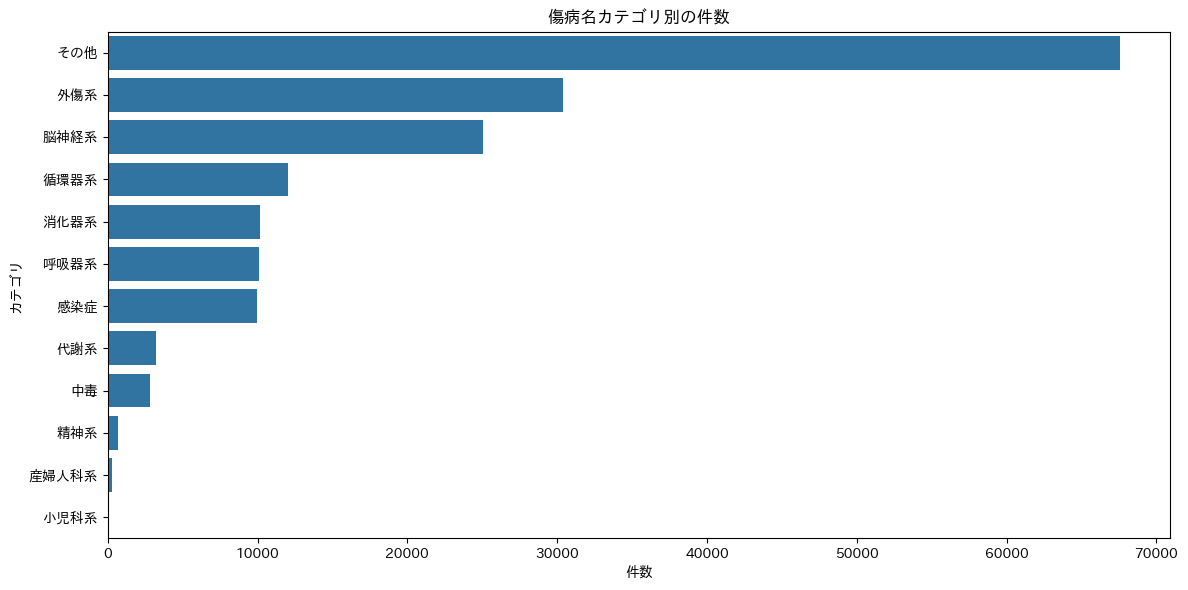


=== 「その他」に分類された傷病名の例（先頭20件）===
心肺停止: 2,383件
熱中症: 1,685件
一過性意識消失: 1,483件
過換気症候群: 1,414件
脳出血: 1,294件
腰痛症: 1,289件
尿路結石: 1,057件
後頭部挫創: 994件
便秘症: 870件
急性腹症: 823件
鼻出血: 777件
意識消失発作: 742件
頸椎捻挫: 685件
前頭部挫創: 684件
意識消失: 605件
イレウス: 563件
尿管結石: 537件
尿閉: 527件
一過性脳虚血発作: 485件
心因反応: 481件


In [9]:
# 傷病名分類分析
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib

# データ読み込み
df = pd.read_csv('../output/傷病名一覧.csv', encoding='utf-8')
print(f"データ総数: {len(df):,}件")

# float型の値を文字列に変換し、NANを適切に処理
def preprocess_disease_name(name):
    if pd.isna(name):
        return "不明"
    if isinstance(name, (int, float)):
        return str(int(name))
    return str(name)

df['傷病名'] = df['傷病名'].apply(preprocess_disease_name)

# 傷病名の正規化関数
def simplify_disease_name(name):
    
    # 括弧内の詳細情報を除去
    name = re.sub(r'[\(（].*?[\)）]', '', name)
    # 疑いの表現を統一
    name = re.sub(r'(の疑い|疑い|疑|と思われる)', '疑い', name)
    return name.strip()

# 分類ルール
rules = {
    '外傷系': r'(骨折|打撲|裂傷|挫傷|外傷|脱臼|擦過傷|刺傷|切創)',
    '循環器系': r'(心筋梗塞|不整脈|高血圧|狭心症|心不全|心臓|血圧|動悸|胸痛)',
    '脳神経系': r'(脳梗塞|くも膜下出血|てんかん|痙攣|めまい|失神|意識障害|頭痛)',
    '消化器系': r'(腹痛|胃炎|胆石|腸炎|下痢|嘔吐|消化管|吐血|下血)',
    '呼吸器系': r'(肺炎|気管支炎|喘息|呼吸困難|咳|痰|気道)',
    '感染症': r'(感染症|敗血症|髄膜炎|発熱|熱発|インフルエンザ)',
    '代謝系': r'(糖尿病|電解質|脱水|低血糖|高血糖)',
    '中毒': r'(中毒|過量摂取|アルコール|薬物)',
    '精神系': r'(統合失調|うつ病|不安|精神|認知症)',
    '産婦人科系': r'(分娩|妊娠|流産|性器出血)',
    '小児科系': r'(熱性痙攣|百日咳|川崎病)'
}

# 分類関数
def classify_disease(name):
    for category, pattern in rules.items():
        if re.search(pattern, name):
            return category
    return 'その他'

# 傷病名の正規化
df['normalized_name'] = df['傷病名'].apply(simplify_disease_name)

# 分類の実行
df['category'] = df['normalized_name'].apply(classify_disease)

# 分類結果の集計
category_counts = df['category'].value_counts()

# 結果の表示
print("\n=== 分類結果 ===")
print("\n各カテゴリの件数:")
for category, count in category_counts.items():
    print(f"{category}: {count:,}件")

# API呼び出し必要数の計算
api_calls_needed = int(category_counts.get('その他', 0))
api_calls_percentage = (api_calls_needed / len(df)) * 100

print(f"\n必要なAPI呼び出し回数: {api_calls_needed:,}回")
print(f"全サンプルに対する割合: {api_calls_percentage:.2f}%")

# 可視化
plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.values, y=category_counts.index)
plt.title('傷病名カテゴリ別の件数')
plt.xlabel('件数')
plt.ylabel('カテゴリ')
plt.tight_layout()
plt.show()

# その他に分類された例の確認
print("\n=== 「その他」に分類された傷病名の例（先頭20件）===")
other_examples = df[df['category'] == 'その他']['傷病名'].value_counts().head(20)
for disease, count in other_examples.items():
    print(f"{disease}: {count:,}件")

データ総数: 172,320件

=== 分類結果 ===

緊急度・重症度別の件数:
最重症: 7,769件
重症: 32,295件
中等症: 26,763件
軽症: 11,884件
要判断: 93,609件

必要なAPI呼び出し回数: 93,609回
全サンプルに対する割合: 54.32%


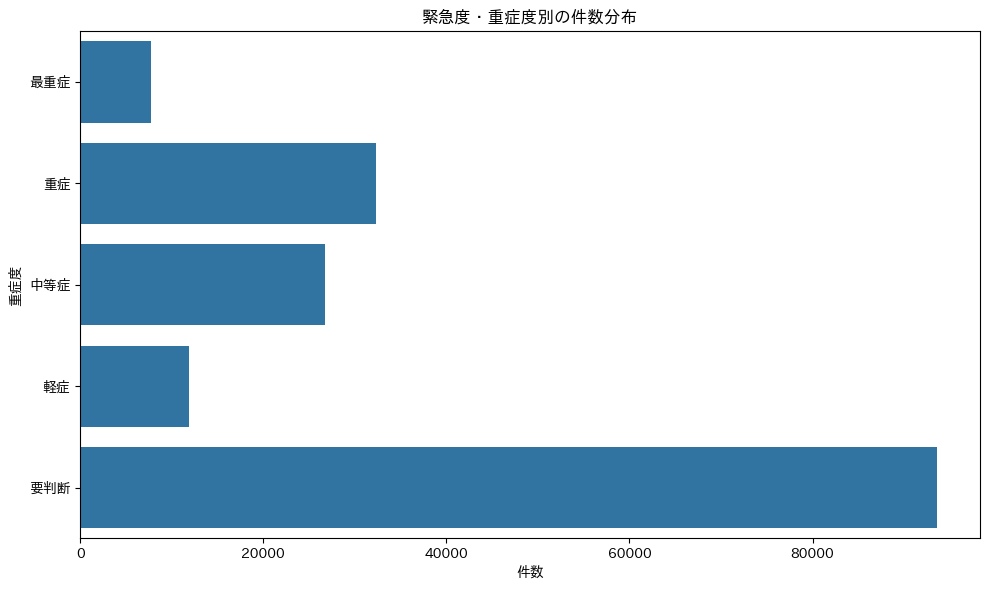


=== システム分類と重症度のクロス集計 ===
severity   最重症     重症    中等症     軽症    要判断
system                                    
その他       6271   2012  10440    484  65003
呼吸器系       144   2017     63      1   7903
外傷系        434  14191   1864  11393   2584
循環器系       233   3941    775      4   7264
消化器系        80   2863   4558      2   2680
脳神経系       607   7271   9063      0   8175

=== 「要判断」に分類された傷病名の例（先頭20件）===
肺炎: 3,707件
心不全: 3,593件
新型コロナウイルス感染症: 2,837件
熱性痙攣: 2,633件
急性アルコール中毒: 1,688件
熱中症: 1,685件
一過性意識消失: 1,483件
誤嚥性肺炎: 1,474件
過換気症候群: 1,414件
尿路感染症: 1,096件
尿路結石: 1,057件
後頭部挫創: 994件
動悸: 984件
神経調節性失神: 970件
てんかん: 926件
便秘症: 870件
胸痛: 851件
急性腸炎: 832件
意識消失発作: 742件
前頭部挫創: 684件


In [12]:
# 緊急度・重症度による分類分析

import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
import numpy as np

# データ読み込み
df = pd.read_csv('../output/傷病名一覧.csv', encoding='utf-8')
print(f"データ総数: {len(df):,}件")

# データの前処理
def preprocess_disease_name(name):
    if pd.isna(name):
        return "不明"
    if isinstance(name, (int, float)):
        return str(int(name))
    return str(name)

df['傷病名'] = df['傷病名'].apply(preprocess_disease_name)

# 緊急度・重症度の分類ルール
severity_rules = {
    '最重症': [
        r'(心肺停止|CPA|心停止)',
        r'(ショック|意識レベル|JCS300|JCS200|GCS[1-6])',
        r'(大量出血|多発性外傷|開放性骨折)',
        r'(くも膜下出血|脳出血|急性大動脈解離)',
        r'(重症熱傷|広範囲熱傷|気道熱傷)',
        r'(窒息|気道閉塞|アナフィラキシー)'
    ],
    '重症': [
        r'(心筋梗塞|狭心症|不整脈)',
        r'(脳梗塞|脳卒中|片麻痺)',
        r'(意識障害|JCS100|JCS20|GCS[7-9])',
        r'(呼吸困難|喘息発作|気管支喘息)',
        r'(骨折|脱臼|重度の打撲)',
        r'(急性腹症|消化管出血|吐血|下血)',
        r'(敗血症|髄膜炎|重症感染症)'
    ],
    '中等症': [
        r'(高血圧|糖尿病|腎不全)',
        r'(腹痛|胃腸炎|食中毒)',
        r'(発熱|頭痛|めまい)',
        r'(切傷|擦過傷|捻挫)',
        r'(鼻出血|耳痛|腰痛)',
        r'(嘔吐|下痢|脱水症)'
    ],
    '軽症': [
        r'(風邪|かぜ|感冒)',
        r'(打撲|擦り傷|突き指)',
        r'(皮膚炎|湿疹|かゆみ)',
        r'(軽度の腹痛|軽度の頭痛)',
        r'(不眠|不安|疲労)'
    ]
}

def classify_severity(name):
    for severity, patterns in severity_rules.items():
        if any(re.search(pattern, name, re.IGNORECASE) for pattern in patterns):
            return severity
    return '要判断'

# 分類の実行
df['severity'] = df['傷病名'].apply(classify_severity)

# 重症度の順序を定義
severity_order = ['最重症', '重症', '中等症', '軽症', '要判断']
df['severity'] = pd.Categorical(df['severity'], categories=severity_order, ordered=True)

# 分類結果の集計
severity_counts = df['severity'].value_counts().reindex(severity_order)

# 結果の表示
print("\n=== 分類結果 ===")
print("\n緊急度・重症度別の件数:")
for severity in severity_order:
    count = severity_counts[severity]
    print(f"{severity}: {count:,}件")

# API呼び出し必要数の計算
api_calls_needed = int(severity_counts.get('要判断', 0))
api_calls_percentage = (api_calls_needed / len(df)) * 100

print(f"\n必要なAPI呼び出し回数: {api_calls_needed:,}回")
print(f"全サンプルに対する割合: {api_calls_percentage:.2f}%")

# 可視化（順序を考慮）
plt.figure(figsize=(10, 6))
sns.barplot(x=severity_counts.values, y=severity_counts.index, order=severity_order)
plt.title('緊急度・重症度別の件数分布')
plt.xlabel('件数')
plt.ylabel('重症度')
plt.tight_layout()
plt.show()

# システム分類関数
def classify_system(name):
    system_rules = {
        '外傷系': r'(骨折|打撲|裂傷|挫傷|外傷|脱臼|擦過傷|刺傷|切創)',
        '循環器系': r'(心筋梗塞|不整脈|高血圧|狭心症|心不全|心臓|血圧|動悸|胸痛)',
        '脳神経系': r'(脳梗塞|くも膜下出血|てんかん|痙攣|めまい|失神|意識障害|頭痛)',
        '消化器系': r'(腹痛|胃炎|胆石|腸炎|下痢|嘔吐|消化管|吐血|下血)',
        '呼吸器系': r'(肺炎|気管支炎|喘息|呼吸困難|咳|痰|気道)'
    }
    
    for system, pattern in system_rules.items():
        if re.search(pattern, name):
            return system
    return 'その他'

df['system'] = df['傷病名'].apply(classify_system)

# クロス集計表の作成（重症度の順序を考慮）
cross_tab = pd.crosstab(df['system'], df['severity'])
print("\n=== システム分類と重症度のクロス集計 ===")
print(cross_tab[severity_order])  # 列の順序を指定

# 要判断に分類された例の確認
print("\n=== 「要判断」に分類された傷病名の例（先頭20件）===")
undetermined_examples = df[df['severity'] == '要判断']['傷病名'].value_counts().head(20)
for disease, count in undetermined_examples.items():
    print(f"{disease}: {count:,}件")

In [14]:
import pandas as pd
import re
from anthropic import Anthropic
import asyncio
from typing import List, Dict
import time
from tqdm import tqdm
from pathlib import Path

# Anthropic APIの設定
anthropic = Anthropic(api_key='YOUR_API_KEY')

# 基本的な臓器系統分類ルール
system_rules = {
    '循環器系': r'(心臓|血圧|不整脈|動悸|胸痛|心筋|血管)',
    '呼吸器系': r'(肺|気管|呼吸|喘息|咳|痰)',
    '消化器系': r'(胃|腸|肝臓|胆嚢|膵臓|腹痛|嘔吐)',
    '脳神経系': r'(脳|神経|意識|めまい|頭痛|痙攣)',
    '筋骨格系': r'(骨|関節|筋肉|腰痛|背部痛)',
    '泌尿器系': r'(腎臓|膀胱|尿)',
    '内分泌系': r'(甲状腺|副腎|糖尿病|ホルモン)',
    '血液系': r'(貧血|出血|白血球|血小板)',
    '皮膚系': r'(皮膚|発疹|かゆみ|湿疹)'
}

class PromptTemplate:
    def __init__(self, template_path: str):
        """プロンプトテンプレートの初期化"""
        self.template = self._load_template(template_path)
    
    def _load_template(self, template_path: str) -> str:
        """テンプレートファイルの読み込み"""
        try:
            with open(template_path, 'r', encoding='utf-8') as f:
                return f.read()
        except FileNotFoundError:
            raise FileNotFoundError(f"プロンプトテンプレートファイルが見つかりません: {template_path}")
    
    def format(self, diseases: List[str]) -> str:
        """プロンプトの生成"""
        diseases_list = "\n".join([f"{i+1}. {d}" for i, d in enumerate(diseases)])
        return self.template.format(
            count=len(diseases),
            diseases_list=diseases_list
        )

def classify_by_rules(name: str) -> str:
    """ルールベースでの分類"""
    for system, pattern in system_rules.items():
        if re.search(pattern, name):
            return system
    return '要API判定'

async def process_batch(batch: List[str], prompt_template: PromptTemplate) -> List[str]:
    """バッチ処理でHaiku APIを呼び出す"""
    try:
        prompt = prompt_template.format(batch)
        response = await anthropic.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=1024,
            messages=[{
                "role": "user",
                "content": prompt
            }]
        )
        results = parse_haiku_response(response.content, len(batch))
        return results
    except Exception as e:
        print(f"Error processing batch: {e}")
        return ['エラー'] * len(batch)

def parse_haiku_response(response: str, expected_length: int) -> List[str]:
    """Haiku APIのレスポンスをパース"""
    results = ['その他'] * expected_length  # デフォルト値を設定
    try:
        lines = response.strip().split('\n')
        for line in lines:
            if '.' in line:
                parts = line.strip().split('.')
                if len(parts) >= 2:
                    idx = int(parts[0]) - 1
                    system = parts[1].strip()
                    if 0 <= idx < expected_length:
                        results[idx] = system
    except Exception as e:
        print(f"Error parsing response: {e}")
    return results

async def process_all_data(df: pd.DataFrame, prompt_template: PromptTemplate, batch_size: int = 20):
    """全データの処理"""
    # まずルールベースで分類
    df['organ_system'] = df['傷病名'].apply(classify_by_rules)
    
    # API判定が必要なケースを抽出
    need_api = df[df['organ_system'] == '要API判定']
    total_api_cases = len(need_api)
    print(f"API判定が必要なケース: {total_api_cases:,}件")
    
    # バッチ処理の準備
    need_api_indices = need_api.index
    results = []
    batches = [need_api['傷病名'].iloc[i:i+batch_size].tolist() 
               for i in range(0, len(need_api), batch_size)]
    
    # プログレスバーでバッチ処理の進捗を表示
    api_calls = 0
    for batch in tqdm(batches, desc="API処理中"):
        batch_results = await process_batch(batch, prompt_template)
        results.extend(batch_results)
        api_calls += 1
        await asyncio.sleep(0.5)  # レート制限対策
    
    # 結果をデータフレームに反映
    df.loc[need_api_indices, 'organ_system'] = results
    
    return df, api_calls

async def main():
    # プロンプトテンプレートの読み込み
    prompt_template = PromptTemplate('prompt_template.txt')
    
    # データ読み込み
    df = pd.read_csv('傷病名一覧.csv', encoding='utf-8')
    print(f"データ総数: {len(df):,}件")
    
    # 処理開始時間
    start_time = time.time()
    
    # データ処理
    processed_df, api_calls = await process_all_data(df, prompt_template)
    
    # 処理時間の計算
    process_time = time.time() - start_time
    
    # 結果の集計と表示
    system_counts = processed_df['organ_system'].value_counts()
    print("\n=== 分類結果 ===")
    for system, count in system_counts.items():
        print(f"{system}: {count:,}件")
    
    print(f"\nAPI呼び出し回数: {api_calls:,}回")
    print(f"処理時間: {process_time:.2f}秒")
    print(f"バッチ処理による削減率: {((1 - api_calls / len(df)) * 100):.1f}%")
    
    # 結果の保存
    processed_df.to_csv('classified_diseases_haiku.csv', index=False)

if __name__ == "__main__":
    asyncio.run(main())

RuntimeError: asyncio.run() cannot be called from a running event loop